In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [2]:
path='./london_merged.csv'
dfk = pd.read_csv(path, parse_dates=['timestamp'])
dfk.info()
#d

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17414 entries, 0 to 17413
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   timestamp     17414 non-null  datetime64[ns]
 1   cnt           17414 non-null  int64         
 2   t1            17414 non-null  float64       
 3   t2            17414 non-null  float64       
 4   hum           17414 non-null  float64       
 5   wind_speed    17414 non-null  float64       
 6   weather_code  17414 non-null  float64       
 7   is_holiday    17414 non-null  float64       
 8   is_weekend    17414 non-null  float64       
 9   season        17414 non-null  float64       
dtypes: datetime64[ns](1), float64(8), int64(1)
memory usage: 1.3 MB


Step 1


In [3]:
def load_data(path, col=None, show=False):
    df = pd.read_csv(path)
    if col is not None:
        df = df[col]
    if show:
        print(df)
    return df

df =load_data(path, col=['cnt', 't1', 't2', 'hum', 'wind_speed'])
df

,cnt,t1,t2,hum,wind_speed
0,182,3.0,2.0,93.0,6.0
1,138,3.0,2.5,93.0,5.0
2,134,2.5,2.5,96.5,0.0
3,72,2.0,2.0,100.0,0.0
4,47,2.0,0.0,93.0,6.5
...,...,...,...,...,...
17409,1042,5.0,1.0,81.0,19.0
17410,541,5.0,1.0,81.0,21.0
17411,337,5.5,1.5,78.5,24.0
17412,224,5.5,1.5,76.0,23.0


Step 2

In [4]:
df_test = pd.read_csv(path, parse_dates=['timestamp'], index_col='timestamp')


df['hour']= df_test.index.hour 
df['month']= df_test.index.month
df['day_of_week']=df_test.index.dayofweek
df['day_of_month']=df_test.index.day
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17414 entries, 0 to 17413
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   cnt           17414 non-null  int64  
 1   t1            17414 non-null  float64
 2   t2            17414 non-null  float64
 3   hum           17414 non-null  float64
 4   wind_speed    17414 non-null  float64
 5   hour          17414 non-null  int64  
 6   month         17414 non-null  int64  
 7   day_of_week   17414 non-null  int64  
 8   day_of_month  17414 non-null  int64  
dtypes: float64(4), int64(5)
memory usage: 1.2 MB


Step 3

In [5]:
def clean_data(series):
    """Fills missing values. 
    
        Interpolate missing values with a linear approximation.
    """
    series_filled = series.interpolate(method='linear')
        
    return series_filled
clean_data(df)

,cnt,t1,t2,hum,wind_speed,hour,month,day_of_week,day_of_month
0,182,3.0,2.0,93.0,6.0,0,1,6,4
1,138,3.0,2.5,93.0,5.0,1,1,6,4
2,134,2.5,2.5,96.5,0.0,2,1,6,4
3,72,2.0,2.0,100.0,0.0,3,1,6,4
4,47,2.0,0.0,93.0,6.5,4,1,6,4
...,...,...,...,...,...,...,...,...,...
17409,1042,5.0,1.0,81.0,19.0,19,1,1,3
17410,541,5.0,1.0,81.0,21.0,20,1,1,3
17411,337,5.5,1.5,78.5,24.0,21,1,1,3
17412,224,5.5,1.5,76.0,23.0,22,1,1,3


Step 5

In [6]:
def min_max_scale(dataframe):
    """ Applies MinMax Scaling
    
        Wrapper for sklearn's MinMaxScaler class.
    """
    mm = MinMaxScaler()
    return mm.fit_transform(dataframe)
df = min_max_scale(df)

Step 6

In [7]:
def split_data(series, test_percent, train_percent):
    #splitting test and train_val
    test_size = int(len(df)*test_percent)
    test_data = df[:test_size]
    train_val_data = df[test_size:]
    #splitting train and val
    train_size = int(len(train_val_data)*train_percent)
    train_data = train_val_data[:train_size]
    val_data = train_val_data[train_size:]
    return train_data, val_data, test_data

train_data, val_data, test_data = split_data(df, 0.1, 0.8)

Step 7

In [8]:
def window_dataset(data, n_steps, n_horizon, batch_size, shuffle_buffer, multi_var=False, expand_dims=False):
    window = n_steps + n_horizon

    if expand_dims:
        ds = tf.expand_dims(data, axis=-1)
        ds = tf.data.Dataset.from_tensor_slices(ds)
    else:
        ds = tf.data.Dataset.from_tensor_slices(data)

    ds = ds.window(window, shift=n_horizon, drop_remainder=True)
    ds = ds.flat_map(lambda x: x.batch(window))
    ds = ds.shuffle(shuffle_buffer)

    if multi_var:
      ds = ds.map(lambda x : (x[:-n_horizon], x[-n_horizon:, :1]))
    else:
      ds = ds.map(lambda x : (x[:-n_horizon], x[-n_horizon:]))

    ds = ds.batch(batch_size).prefetch(1)
    return ds


In [9]:
#hyperparameters
n_steps = 24*30 #30 days data
n_horizon = 24
batch_size = 32
shuffle_buffer = 500
n_features = 9

In [10]:
train_ds = window_dataset(train_data, n_steps, n_horizon, batch_size, shuffle_buffer, multi_var=True)
val_ds = window_dataset(val_data, n_steps, n_horizon, batch_size, shuffle_buffer, multi_var=True)
test_ds = window_dataset(test_data, n_steps, n_horizon, batch_size, shuffle_buffer, multi_var=True)

In [11]:
for idx,(x,y) in enumerate(val_ds):
    print("x = ", x.numpy().shape)
    print("y = ", y.numpy().shape)
    break

x =  (32, 720, 9)
y =  (32, 24, 1)


In [12]:
print(train_ds.element_spec)

(TensorSpec(shape=(None, None, 9), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))


Step 8

In [13]:
###########----BASELINE MODEL----##########
model_baseline = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(n_steps, n_features)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])
model_baseline.compile(loss=tf.keras.losses.Huber(),
                   metrics=['mae'],
                   optimizer=tf.keras.optimizers.SGD(momentum=0.9))
print('---------------------Baseline model-------------------------')
model_baseline.fit(train_ds, epochs=10)

---------------------Baseline model-------------------------
Epoch 1/10
16/16 [==============================] - 3s 25ms/step - loss: 0.5869 - mae: 0.8181
Epoch 2/10
16/16 [==============================] - 0s 4ms/step - loss: 0.0114 - mae: 0.1118
Epoch 3/10
16/16 [==============================] - 0s 4ms/step - loss: 0.0103 - mae: 0.1179
Epoch 4/10
16/16 [==============================] - 0s 4ms/step - loss: 0.0101 - mae: 0.1140
Epoch 5/10
16/16 [==============================] - 0s 4ms/step - loss: 0.0101 - mae: 0.1112
Epoch 6/10
16/16 [==============================] - 0s 4ms/step - loss: 0.0101 - mae: 0.1112
Epoch 7/10
16/16 [==============================] - 0s 4ms/step - loss: 0.0101 - mae: 0.1121
Epoch 8/10
16/16 [==============================] - 0s 4ms/step - loss: 0.0100 - mae: 0.1119
Epoch 9/10
16/16 [==============================] - 0s 4ms/step - loss: 0.0101 - mae: 0.1115
Epoch 10/10
16/16 [==============================] - 0s 4ms/step - loss: 0.0101 - mae: 0.1115


In [20]:
###############-----------Finding optimal Learning rate value------------##############3
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch : 1e-6*10**(epoch/20)
)
model_tune = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(32, 6, activation='relu', padding='causal', input_shape=(n_steps, n_features)),
    tf.keras.layers.MaxPooling1D(),
    tf.keras.layers.Conv1D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling1D(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(n_horizon)
])

model_tune.compile(loss=tf.keras.losses.Huber(),
              metrics='mae',
              optimizer=tf.keras.optimizers.SGD(momentum=0.9))
model_tune.summary()
history_tune = model_tune.fit(train_ds, epochs=200, callbacks=[lr_scheduler])

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 720, 32)           1760      
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 360, 32)          0         
 1D)                                                             
                                                                 
 conv1d_9 (Conv1D)           (None, 358, 64)           6208      
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 179, 64)          0         
 1D)                                                             
                                                                 
 bidirectional_8 (Bidirectio  (None, 179, 80)          33600     
 nal)                                                            
                                                      

(1e-06, 10000.0, 0.0, 1.0)

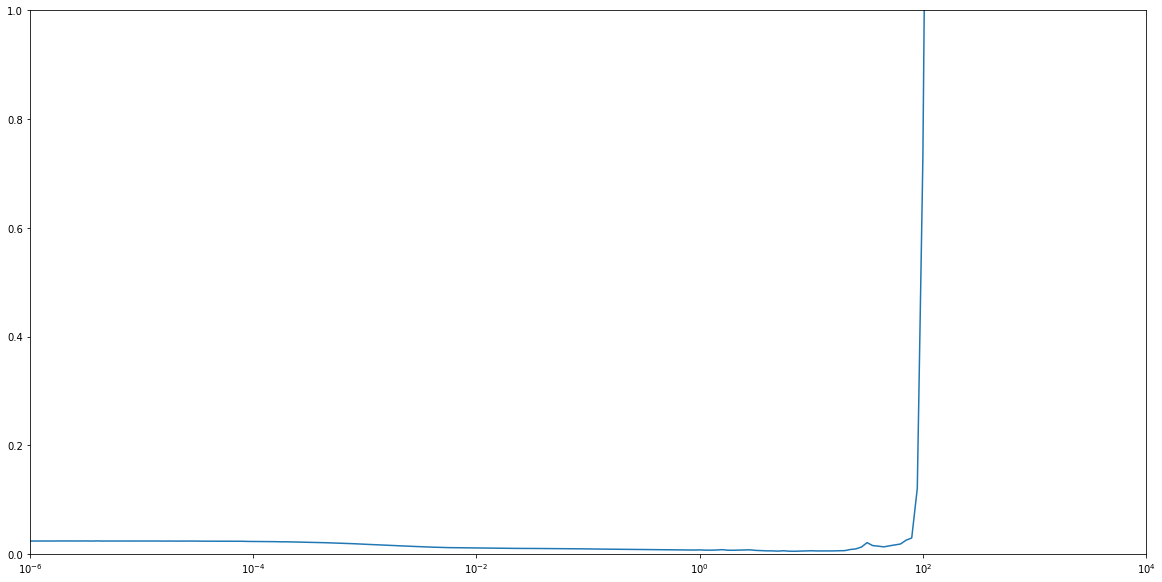

In [28]:
##########--------plotting learning rate ----------##########
plt.figure(figsize=(20,10))
plt.semilogx(history_tune.history['lr'], history_tune.history['loss'])
plt.axis([10e-7, 10e+3, 0, 1])


In [29]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(32, 6, activation='relu', padding='causal', input_shape=(n_steps, n_features)),
    tf.keras.layers.MaxPooling1D(),
    tf.keras.layers.Conv1D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling1D(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(n_horizon)
])

model.compile(loss=tf.keras.losses.Huber(),
              metrics='mae',
              optimizer=tf.keras.optimizers.SGD(lr=1e-2, momentum=0.9))
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_10 (Conv1D)          (None, 720, 32)           1760      
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 360, 32)          0         
 g1D)                                                            
                                                                 
 conv1d_11 (Conv1D)          (None, 358, 64)           6208      
                                                                 
 max_pooling1d_11 (MaxPoolin  (None, 179, 64)          0         
 g1D)                                                            
                                                                 
 bidirectional_10 (Bidirecti  (None, 179, 80)          33600     
 onal)                                                           
                                                      

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [31]:
history = model.fit(train_ds, epochs=500, validation_data=val_ds)

Epoch 1/500
16/16 [==============================] - 1s 44ms/step - loss: 0.0166 - mae: 0.1298 - val_loss: 0.0109 - val_mae: 0.0998
Epoch 2/500
16/16 [==============================] - 1s 38ms/step - loss: 0.0142 - mae: 0.1201 - val_loss: 0.0096 - val_mae: 0.0946
Epoch 3/500
16/16 [==============================] - 1s 35ms/step - loss: 0.0129 - mae: 0.1160 - val_loss: 0.0090 - val_mae: 0.0952
Epoch 4/500
16/16 [==============================] - 1s 36ms/step - loss: 0.0121 - mae: 0.1141 - val_loss: 0.0088 - val_mae: 0.0971
Epoch 5/500
16/16 [==============================] - 1s 35ms/step - loss: 0.0114 - mae: 0.1121 - val_loss: 0.0087 - val_mae: 0.0984
Epoch 6/500
16/16 [==============================] - 1s 34ms/step - loss: 0.0111 - mae: 0.1123 - val_loss: 0.0086 - val_mae: 0.0994
Epoch 7/500
16/16 [==============================] - 1s 35ms/step - loss: 0.0110 - mae: 0.1119 - val_loss: 0.0085 - val_mae: 0.0997
Epoch 8/500
16/16 [==============================] - 1s 35ms/step - loss: 0.

Step 9


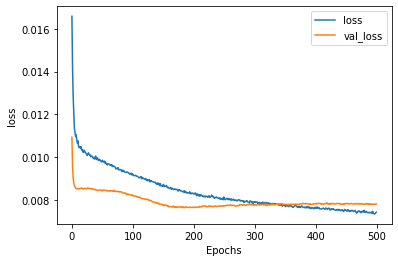

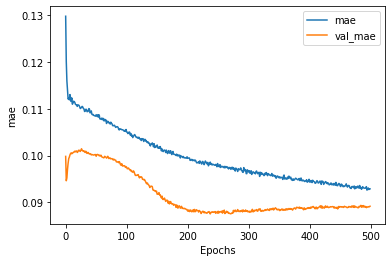

In [32]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'loss')
plot_graphs(history, 'mae')

In [33]:
eval = model.evaluate(test_ds)
eval

2/2 [==============================] - 0s 74ms/step - loss: 0.0085 - mae: 0.1033


[0.00846005603671074, 0.1033313050866127]

2/2 [==============================] - 1s 42ms/step
First Two Weeks of Predictions


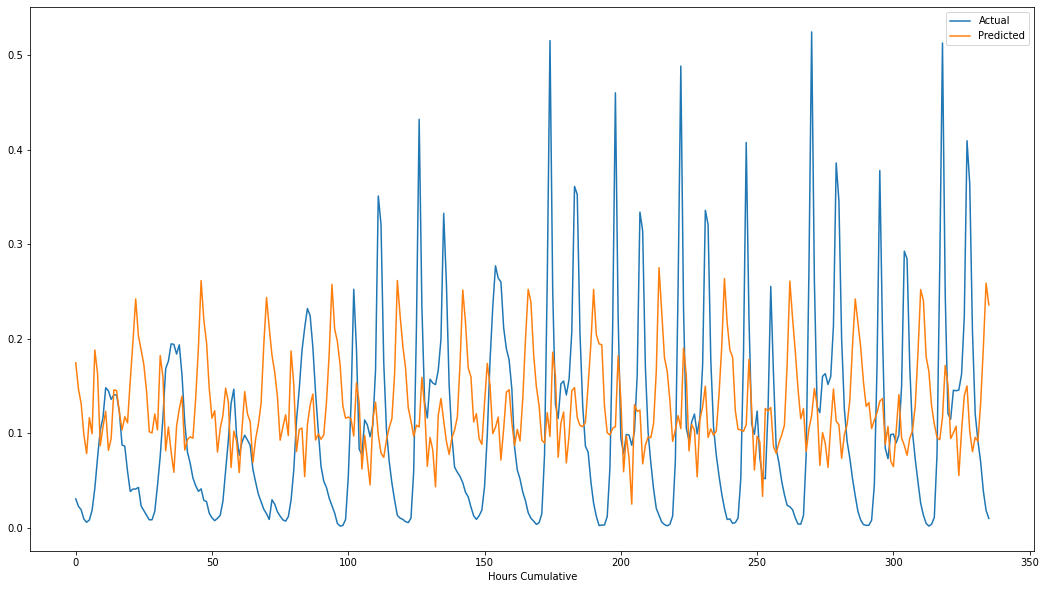

In [34]:
fig, axs = plt.subplots(1, 1, figsize=(18, 10))
days = 14

vline = np.linspace(0, days*24, days+1)


test = test_ds
preds = model.predict(test)
xbatch, ybatch = iter(test).get_next()
plt.plot(ybatch.numpy()[:days].reshape(-1))
plt.plot(preds[:days].reshape(-1))
plt.legend(["Actual", "Predicted"])

plt.xlabel("Hours Cumulative")
print(f'First Two Weeks of Predictions')

In [182]:
def plot_series(time, series, format="-", start=0, end=None):
    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
 
    if type(series) is tuple:

      for series_num in series:
        # Plot the time series data
        plt.plot(time[start:end], series_num[start:end], format)
    else:
      # Plot the time series data
      plt.plot(time[start:end], series[start:end], format)

    # Label the x-axis
    plt.xlabel("Time")

    # Label the y-axis
    plt.ylabel("Value")

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

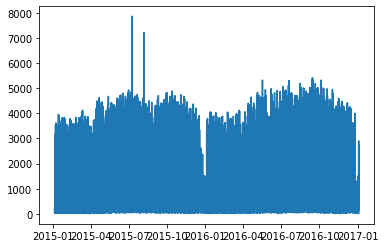

In [178]:
plt.plot(df_test.index, df_test['cnt'])

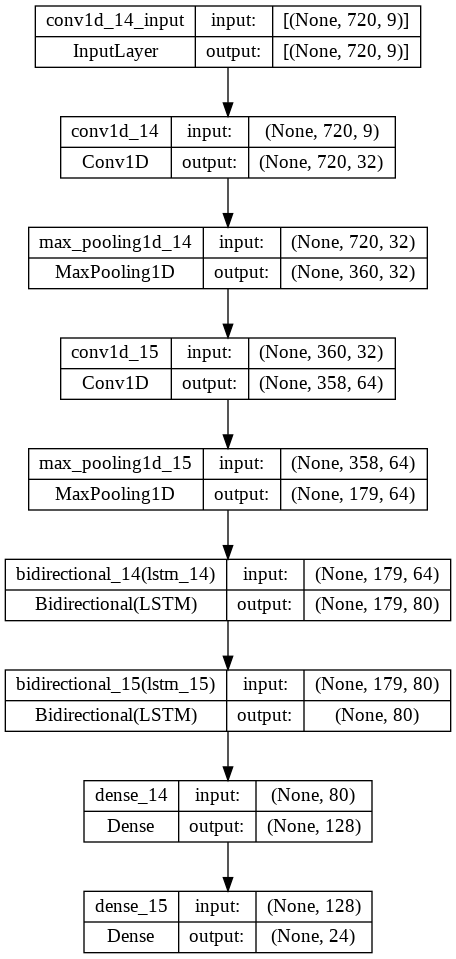

In [166]:
tf.keras.utils.plot_model(model, show_shapes=True)